In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructField, StructType, DoubleType,MapType, StringType,ArrayType, FloatType, TimestampType, IntegerType
from cerebralcortex.core.datatypes import DataStream
from cerebralcortex.core.metadata_manager.stream.metadata import Metadata, DataDescriptor, \
ModuleMetadata
from scipy import signal
from scipy.interpolate import interp1d
from cerebralcortex import Kernel
from scipy.stats import skew,kurtosis,mode
CC = Kernel("/home/jupyter/cc3_conf/", study_name='mperf')

Resampling mperf data to 20Hz and computes the magnitude and applies activity recognition model

In [ ]:
import tempfile
import tensorflow

def interpolate_acl(a,window_size=10,fs_now=25,fs_new=20):
    x_now = np.linspace(0,window_size,window_size*fs_now)
    f = interp1d(x_now,a,axis=0,fill_value='extrapolate')
    x_new = np.linspace(0,window_size,window_size*fs_new)
    return f(x_new)

class ModelWrapperPickable:

    def __init__(self, model):
        self.model = model

    def __getstate__(self):
        model_str = ''
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            tensorflow.keras.models.save_model(self.model, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            self.model = tensorflow.keras.models.load_model(fd.name)


def isDatapointsWithinRange(red,infrared,green):
        red = np.asarray(red, dtype=np.float32)
        infrared = np.asarray(infrared, dtype=np.float32)
        green = np.asarray(green, dtype=np.float32)
        a =  len(np.where((red >= 20000)& (red<=200000))[0]) < .33*10*25
        b = len(np.where((infrared >= 80000)& (infrared<=230000))[0]) < .33*10*25
        c = len(np.where((green >= 500)& (green<=20000))[0]) < .33*10*25
        if a and b and c:
            return False
        return True            

            
def compute_quality(red,infrared,green):
        """
        :param window: a window containing list of DataPoints
        :return: an integer reptresenting the status of the window 0= attached, 1 = not attached
        """
        if len(red)==0:
            return 'Not Worn' #not attached
        if not isDatapointsWithinRange(red,infrared,green):
            return 'Not Worn'
        red_mean = np.mean(red)
        ir_mean = np.mean(infrared)
        green_mean = np.mean(green)
        if red_mean < 5000 and ir_mean < 5000:
            return 'Not Worn'
        if not (red_mean>green_mean and ir_mean>red_mean):
            return 'Not Worn'
        diff = 30000
        if red_mean<130000:
            diff = 10000
        if not red_mean - green_mean > diff:
            return 'Not Worn'
        if not ir_mean - red_mean >diff:
            return 'Not Worn'
        return 'Worn'            
            

def compute_magnitude_and_activity(data,
                                   Fs = 25,
                                   window_size = 10,
                                   stream_name = 'org.md2k.feature.motionsensehrv.decoded.rightwrist.all',
                                   new_Fs = 20,
                                   filename1 = './models/activity_estimator_both_magnitude.hdf5',
                                   filename2 = './models/activity_estimator_wisdm_magnitude.hdf5'):
            
    model = load_model(filename1)

    model_wrapper= ModelWrapperPickable(model)


    model_wisdm = load_model(filename2)

    model_wrapper_wisdm= ModelWrapperPickable(model_wisdm)


    data = data.select('localtime','timestamp','aclx','acly','aclz','user','version','red','infrared','green')

    data = data.withColumn('magnitude',F.sqrt(F.pow(F.col('aclx'),2)+F.pow(F.col('acly'),2)+F.pow(F.col('aclz'),2))).drop('aclx','acly','aclz')

    data = data.withColumn('time',F.col('timestamp').cast('double'))

    data = data.withColumn('magnitude_time',F.array('time','magnitude')).drop('time','magnitude')

    groupbycols = ['user','version',F.window('timestamp',windowDuration=str(window_size)+' seconds', startTime='0 seconds')]
    data_windowed_10 = data.groupBy(groupbycols).agg(F.collect_list('magnitude_time'),
                                                     F.collect_list('localtime'),
                                                    F.collect_list('red'),
                                                    F.collect_list('infrared'),
                                                    F.collect_list('green'))

    data_windowed_10 = data_windowed_10.withColumnRenamed('collect_list(magnitude_time)','magnitude_time')
    data_windowed_10 = data_windowed_10.withColumnRenamed('collect_list(localtime)','localtime')
    
    data_windowed_10 = data_windowed_10.withColumnRenamed('collect_list(red)','red')
    data_windowed_10 = data_windowed_10.withColumnRenamed('collect_list(infrared)','infrared')
    data_windowed_10 = data_windowed_10.withColumnRenamed('collect_list(green)','green')

    qfunction = F.udf(compute_quality,StringType())
    data_windowed_10 = data_windowed_10.withColumn('quality',qfunction(data_windowed_10['red'],data_windowed_10['infrared'],data_windowed_10['green']))

    data_windowed_10 = data_windowed_10.drop('red','infrared','green')
    
    data_windowed_10 = data_windowed_10.filter(F.col('quality')=='Worn').drop('quality')

    
    data_windowed_10 = data_windowed_10.withColumn('localtime',F.col('localtime').getItem(0))

    data_windowed_10 = data_windowed_10.withColumn('length',F.size('magnitude_time'))

    data_windowed_10 = data_windowed_10.filter(F.col('length')==window_size*Fs).drop('length')

    data_windowed_10 = data_windowed_10.withColumn('timestamp',F.col('window').start).withColumn('start',F.col('window').start).withColumn('end',F.col('window').end).drop('window')

    data_windowed_10  = data_windowed_10.withColumn('day',F.date_format('localtime',"yyyyMMdd"))

    final_activity_list = ['Brushing','Cycling','Sports','Eating','Driving',
                           'Exercise','Sitting','Stairs','Standing','Walking']
    final_activity_dict = {a:i for i,a in enumerate(final_activity_list)}
    final_activity_dict_reverse = {i:a for i,a in enumerate(final_activity_list)}

    activity_list_wisdm = ['Sitting','Stairs','Jogging','Typing','Standing','Walking','Brushing','Eating','Drinking','Kicking',
                    'Playing Catch','Dribbling','Writing','Clapping','Folding Clothes']
    print(data_windowed_10.schema)
    schema = StructType(list(data_windowed_10.schema)[:2]+list(data_windowed_10.schema)[3:]+[StructField("magnitude", ArrayType(DoubleType())),
                                                                                            StructField("prediction", StringType()),
                                                                                            StructField("prediction_wisdm", StringType()),
                                                                                            StructField("mean", DoubleType()),
                                                                                            StructField("std", DoubleType()),
                                                                                            StructField("skew", DoubleType()),
                                                                                            StructField("kurtosis", DoubleType())])

    def smooth_predictions(df):
        if df.shape[0]<3:
            return pd.DataFrame([],columns=columns)
        for name in ['prediction','prediction_wisdm']:
            y_activities = list(df[name])
            m_act = mode(y_activities)[0][0]
            df[name] = [m_act]*df.shape[0]
        return df

    columns = [a.name for a in schema.fields]
    @pandas_udf(schema, PandasUDFType.GROUPED_MAP)
    def interpolate_acl_magnitude(df):
        df['magnitude_time'] = df['magnitude_time'].apply(lambda b:np.array([np.array(a) for a in b]).reshape(window_size*Fs,2))
        df['magnitude_time'] = df['magnitude_time'].apply(lambda a:a[a[:,0].argsort()])
        df['magnitude_time'] = df['magnitude_time'].apply(lambda a:a[:,1].reshape(window_size*Fs,1))
        df['magnitude'] = df['magnitude_time'].apply(lambda a:interpolate_acl(a).reshape(1,window_size*new_Fs,1))
        X = np.concatenate(list(df['magnitude']))
        y_pred = model_wrapper.model.predict(X).argmax(axis=1)
        df['prediction'] = list(y_pred.reshape(-1))
        df['prediction'] = df['prediction'].apply(lambda a:final_activity_dict_reverse[a])

        y_pred = model_wrapper_wisdm.model.predict(X).argmax(axis=1)
        df['prediction_wisdm'] = list(y_pred.reshape(-1))
        df['prediction_wisdm'] = df['prediction_wisdm'].apply(lambda a:activity_list_wisdm[a])   
        df['magnitude'] = df['magnitude'].apply(lambda a:a.reshape(-1)) 
        df['mean'] = df['magnitude'].apply(lambda a:np.mean(a))
        df['std'] = df['magnitude'].apply(lambda a:np.std(a))
        df['skew'] = df['magnitude'].apply(lambda a:skew(a))
        df['kurtosis'] = df['magnitude'].apply(lambda a:kurtosis(a))
        df = df[columns]
        df = df.groupby(pd.Grouper(key='timestamp',freq=str(6*window_size)+'S'),as_index=False).apply(smooth_predictions)
        return df

    data_interpolated = data_windowed_10.groupBy(['user','version','day']).apply(interpolate_acl_magnitude)
    schema = data_interpolated.schema
    stream_metadata = Metadata()
    stream_metadata.set_name(stream_name+'.activity').set_description("Activity Computed")
    for field in schema.fields:
        stream_metadata.add_dataDescriptor(
            DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
        )
    stream_metadata.add_module(
        ModuleMetadata().set_name("activity datastream") \
        .set_attribute("url", "https://md2k.org").set_author(
            "Md Azim Ullah", "mullah@memphis.edu"))
    stream_metadata.is_valid()
    data_interpolated.printSchema()
    ds = DataStream(data=data_interpolated,metadata=stream_metadata)
    return ds
# CC.save_stream(ds,overwrite=True)

In [ ]:
stream_name = 'org.md2k.feature.motionsensehrv.decoded.rightwrist.all'
data = CC.get_stream(stream_name)
data_activity = compute_magnitude_and_activity(data,stream_name=stream_name)
CC.save_stream(data_activity,overwrite=True)

In [ ]:
right_data = CC.get_stream('org.md2k.feature.motionsensehrv.decoded.leftwrist.all.activity')

In [ ]:
right_data.count()*10/3600

In [ ]:
count_data = right_data.select('user','prediction','day').groupBy(['user','prediction','day']).count()
df = count_data.toPandas()
import pickle
pickle.dump(df,open('./data/left_wrist_count.p','wb'))

In [ ]:
right_data = CC.get_stream('org.md2k.feature.motionsensehrv.decoded.rightwrist.all.activity')

count_data = right_data.select('user','prediction','day').groupBy(['user','prediction','day']).count()
df = count_data.toPandas()
import pickle
pickle.dump(df,open('./data/right_wrist_count.p','wb'))

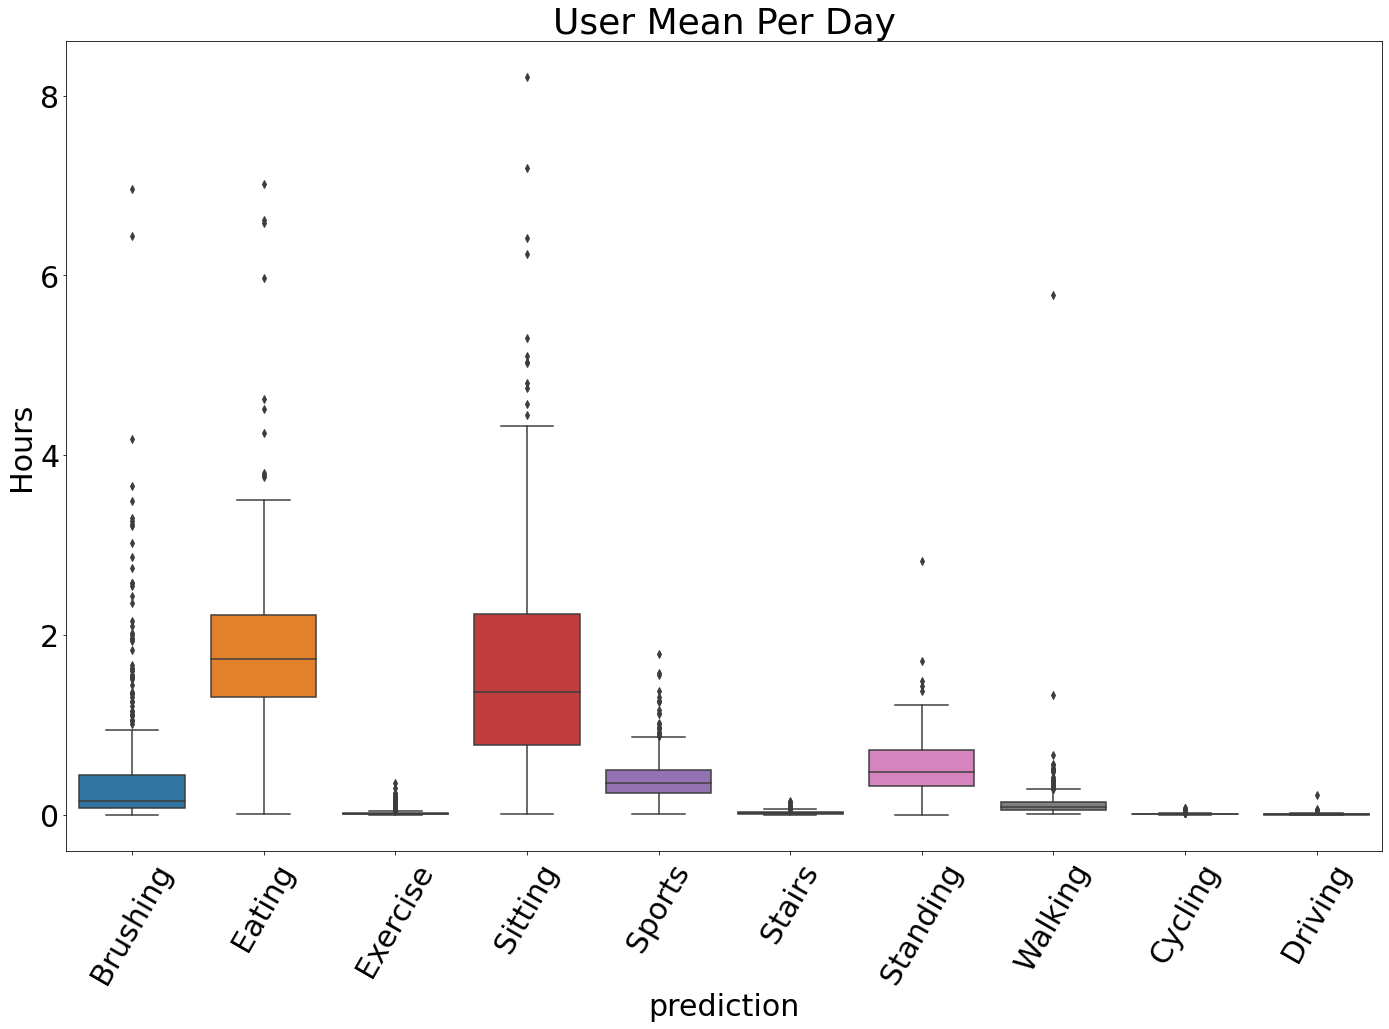

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
df = pickle.load(open('./data/right_wrist_count.p','rb'))
df['count'] = df['count'].apply(lambda a:(a*10)/3600)

df_user_mean = df.groupby(['user','prediction'],as_index=False).mean()
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,15))
sns.boxplot(x='prediction',y='count',data=df_user_mean)
plt.xticks(rotation='60')
plt.ylabel('Hours')
plt.title('User Mean Per Day')
plt.tight_layout()
plt.savefig('./images/user_mean_per_day.png')
plt.show()

In [105]:
import pickle
import pandas as pd
df = pickle.load(open('./data/right_wrist_count.p','rb'))
df['count'] = df['count'].apply(lambda a:(a*10)/3600)
df = df[df.prediction != 'Cycling']
df = df.replace('Sitting','Stationery\n(Sitting, Eating, Brushing)')
df = df.replace('Eating','Stationery\n(Sitting, Eating, Brushing)')
df = df.replace('Brushing','Stationery\n(Sitting, Eating, Brushing)')
df = df.replace('Standing','Stationery\n(Sitting, Eating, Brushing)')
df = df.replace('Sports','High Intensity Activity\n(Sports, Exercise)')
df = df.replace('Exercise','High Intensity Activity\n(Sports, Exercise)')

# for a in df['prediction'].unique():
#     df_walking = df[df['prediction']==a]

#     plt.figure(figsize=(20,10))
#     plt.hist(df_walking[['user','count']].groupby(['user']).mean()['count'],20,density=False)
#     plt.title('Mean '+a+' hours for Users')
#     plt.xlabel('Hours')
#     plt.tight_layout()
#     plt.savefig('./images/Mean'+a+'.png')
#     plt.show()

In [107]:
df[df.prediction=='Walking']['count'].sum()

2292.052777777778

In [108]:
df[df.prediction=='Stationery\n(Sitting, Eating, Brushing)']['count'].sum()

95568.9611111111

In [110]:
df[df.prediction=='Stairs']['count'].sum()

343.96666666666664

In [111]:
df[df.prediction=='Driving']['count'].sum()

2.338888888888889

In [112]:
df[df.prediction=='High Intensity Activity\n(Sports, Exercise)']['count'].sum()

8570.675000000001

In [7]:
df_walking['count'].sum()/len(df_walking['day'].unique())

10.611355452674898

In [8]:
users = df_walking.groupby(['user'],as_index=False).mean().sort_values('count')[::-1]['user'].values

In [10]:
pickle.dump(users,open('./data/users.p','wb'))

In [35]:
df1 = df.copy()
# activities = ['Standing','Sitting','Eating','Brushing']
# df1['prediction'][df1.prediction.isin(activities)] = ['Stationery']*len(df1['prediction'][df1.prediction.isin(activities)])

/cerebralcortex/kessel_jupyter_virtualenv/cc33/lib64/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [97]:
import pickle
import pandas as pd
df1 = pickle.load(open('./data/right_wrist_count.p','rb'))

In [98]:
df1['count'] = df1['count'].apply(lambda a:(a*10)/3600)

def get_data(df):
    if df['count'].sum()<1:
        return pd.DataFrame([],columns=df.columns)
    return df

df1  = df1.groupby(['user','day'],as_index=False).apply(get_data)

In [99]:
df1 = df1[df1.prediction != 'Cycling']
df1 = df1.replace('Sitting','Stationery\n(Sitting, Eating, Brushing)')
df1 = df1.replace('Eating','Stationery\n(Sitting, Eating, Brushing)')
df1 = df1.replace('Brushing','Stationery\n(Sitting, Eating, Brushing)')
df1 = df1.replace('Standing','Stationery\n(Sitting, Eating, Brushing)')
df1 = df1.replace('Sports','High Intensity Activity\n(Sports, Exercise)')
df1 = df1.replace('Exercise','High Intensity Activity\n(Sports, Exercise)')

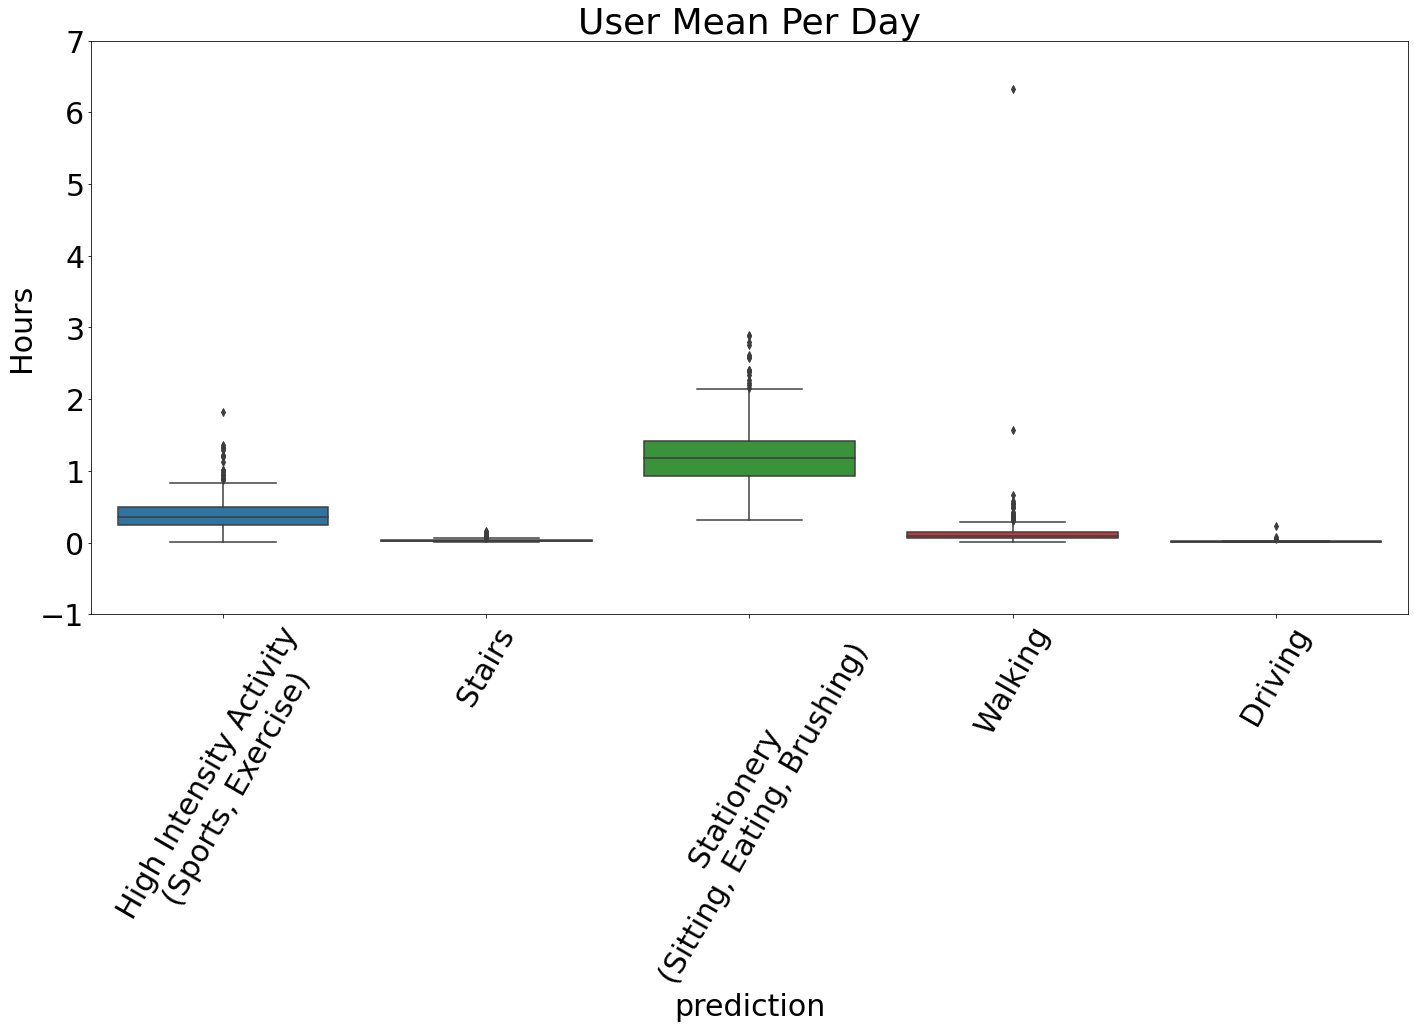

389

In [103]:
df_user_mean = df1.groupby(['user','prediction'],as_index=False).mean()
plt.rcParams.update({'font.size':30})
plt.figure(figsize=(20,15))
sns.boxplot(x='prediction',y='count',data=df_user_mean)
plt.xticks(rotation='60')
plt.ylabel('Hours')
plt.title('User Mean Per Day')
plt.tight_layout()
plt.ylim([-1,7])
plt.savefig('./images/user_mean_per_day.png')
plt.show()
len(users)

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(df_user_mean['count'][df_user_mean['prediction'].isin(['Walking','Stairs','Sports','Exercise'])],300,density=True)
plt.xlim([0,2])
plt.title('Moving Hours per day distribution')
plt.xlabel('Hours')
plt.savefig('./images/moving_hours_per_day.png')
plt.show()

In [ ]:
# final_activity_list = ['Brushing','Cycling','Sports','Eating','Driving',
#                        'Exercise','Sitting','Stairs','Standing','Walking']
def percentage(df):
    activities = np.unique(df['prediction'])
    result  = []
    for a in activities:
        result.append(100*df['count'][df['prediction']==a].values[0]/df['count'].sum())
    users = [df.user.values[0]]*len(result)
    return pd.DataFrame({'activities':activities,'user':users,'percentage':result})

df_user_percentage = df_user_mean.groupby('user',as_index=False).apply(percentage)

In [ ]:
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(20,10))
sns.boxplot(x='activities',y='percentage',data=df_user_percentage)
plt.xticks(rotation=60)
plt.savefig('./images/user_percentage_per_day.png')
plt.show()

In [ ]:
stream_name = 'org.md2k.feature.motionsensehrv.decoded.leftwrist.all'

In [ ]:
data = CC.get_stream(stream_name)

In [ ]:
data.select('user').distinct().count()

In [ ]:
data_activity.count()

In [ ]:
61692/(25*3600)

In [ ]:
data.count()

In [ ]:
data_activity.show(4,False)

In [ ]:
data = CC.get_stream('activity_type--org.md2k.phonesensor--phone')

In [ ]:
data.printSchema()

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('CPU')

In [ ]:
import pytorch

In [ ]:
20*3*330*70

In [ ]:
1386000,500,3

In [88]:
directory = './data/right_wrist/'

In [89]:
len(os.listdir(directory))

283

In [75]:
for a in os.listdir(directory)[:1]:
    df = pickle.load(open(directory+a,'rb'))

In [76]:
df['prediction'].unique()

array(['Walking'], dtype=object)